In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

%matplotlib inline

### GOES Tb vs snow and soil temps

define functions

In [2]:
def plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color='k', alpha=0.1, heatmap_cmap=None):
    _x = _x.sel(datetime=slice(startdate, enddate))
    _y = _y.sel(datetime=slice(startdate, enddate))

    # Linear regression between x and y
    x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar = quickstats(_x, _y)
    fit = slope*x + intercept
    # Compute some more stats between x and y:
    #print('r-squared = {}'.format(np.round(r_value**2,2)))

    
    plt.figure(figsize=(5.5,5.5))
    # Plot gridlines
    plt.grid(color='grey', linestyle=':', linewidth=1)
    # Plot points and best linear fit
    #plt.plot(x, fit, ':r', zorder=99)

    if heatmap_cmap == None:
        plt.plot(x,y,'.',color=point_color,markersize=5,alpha=alpha)
    else:
        # Create 2d histogram "heatmap"
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        # Plot "heatmap"
        plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=heatmap_cmap)
        plt.colorbar(label='number of records')

    # Plot 1-to-1 line
    plt.plot([-30,30],[-30,30],':k')

    # Set axes limits
    plt.xlim([-30,30])
    plt.ylim([-30,30])

    # Set axes labels, plot title
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title('{} -- {}\n$RMSE$ = {}, mean bias = {}'.format(startdate,enddate,
                                                            np.round(rmse,2),
                                                           np.round(mbe,2)))
    plt.tight_layout()
    
    return None

def quickstats(_x,_y):
    # remove nan values from input _x and _y before linear regression
    df1 = pd.DataFrame({'x': _x})
    df1['y'] = _y
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Linear regression between x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean(np.square(y - x)))
    
    # Mean Bias Error
    mbe = np.mean(y - x)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(y - x))
    
    # Covariance
    X = np.stack((x, y), axis=0)
    covar = np.cov(X)
    
    return x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar

Open data

In [3]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()

compute mean soil temp

In [4]:
soil_temps = cues_ds[['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)',
'soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)',
'soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)']]

cues_ds['mean_soil_temp'] = xr.DataArray( soil_temps.to_dataframe().mean(axis=1) )

set min soil temp threshold

In [5]:
soil_t_threshold = 1 # deg C

make snow temp plot

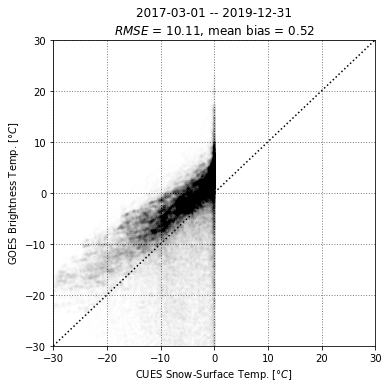

In [6]:
startdate = '2017-03-01'
enddate = '2019-12-31'

_x = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where((cues_ds.cloud_flag==0))
x_label = 'CUES Snow-Surface Temp. [$\degree C$]'

_y = cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0))
y_label = 'GOES Brightness Temp. [$\degree C$]'

point_color = 'k'
heatmap_cmap = None#'Greys'

plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color, 0.005, heatmap_cmap)      

make soil temp plot

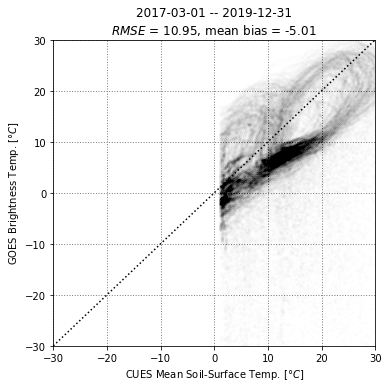

In [7]:
startdate = '2017-03-01'
enddate = '2019-12-31'

_x = cues_ds.mean_soil_temp.where((cues_ds.cloud_flag==0) & (cues_ds.mean_soil_temp > soil_t_threshold))
x_label = 'CUES Mean Soil-Surface Temp. [$\degree C$]'

_y = cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) & (cues_ds.mean_soil_temp > soil_t_threshold))
y_label = 'GOES Brightness Temp. [$\degree C$]'

point_color = 'k'
heatmap_cmap = None#'Greys'

plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color, 0.005, heatmap_cmap)      